In [1]:
import os

# 현재 경로 확인
current_dir = os.getcwd()
# 1단계 상위 디렉토리 경로 생성
parent_dir = os.path.abspath(os.path.join(current_dir, os.pardir))
os.chdir(parent_dir)

In [2]:
import numpy as np
import pandas as pd
import torch
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from vae_earlystopping import EarlyStopping
from model.m25odel_2 import MultiDecoderCondVAE
from loss.l25oss import integrated_loss_fn


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
train_loader = torch.load('torch/train_loader.pt',weights_only=False)
val_loader = torch.load('torch/val_loader.pt',weights_only= False)
test_loader = torch.load('torch/test_loader.pt',weights_only= False)

In [5]:
x_sample,c_sample = next(iter(train_loader))
x_dim = x_sample.shape[1]
c_dim = c_sample.shape[1]
x_dim,c_dim

(23, 15)

In [6]:
model = MultiDecoderCondVAE(x_dim,c_dim,z_dim=7,z1_dim=32).to(device)
early_stopping = EarlyStopping(patience=40,min_delta = 1e-9)
optimizer = optim.Adam(model.parameters(),lr = 0.007209650083205326, weight_decay=1e-5)

In [7]:
history = {'train_loss':[],'train_bce':[],'train_kl':[],'val_loss':[],'val_bce':[],'val_kl':[]}
epochs = 600

In [8]:
for epoch in range(1,1+epochs):
    model.train()
    t_loss,t_mse,t_kl = 0,0,0
    beta = 0.01
    for x,c in train_loader:
        x,c = x.to(device),c.to(device)
        optimizer.zero_grad()
        bce_logit,binary_out,x_hat,z_mu,z_logvar, c_hat = model(x,c)
        loss_dict = integrated_loss_fn(bce_logit, x_hat,x,z_mu,z_logvar, c_hat, c)
        loss_dict['loss'].backward()
        optimizer.step()
        t_loss += loss_dict['loss'].item()
        t_mse += loss_dict['bce_loss'].item()
        t_kl += loss_dict['kl_loss'].item()

    model.eval()
    v_loss = 0
    v_mse = 0
    v_kl = 0
    y_true_all, y_pred_all,y_hat_all = [], [], []
    threshold = 0.5 
    with torch.no_grad():
        for v_x,v_c in val_loader:
            v_x,v_c = v_x.to(device),v_c.to(device)
            v_bce_logit,v_binary_out,v_x_hat ,v_z_mu,v_z_logvar,v_c_hat = model(v_x,v_c)
            loss_dict = integrated_loss_fn(v_bce_logit, v_x_hat,v_x,v_z_mu,v_z_logvar,v_c_hat,v_c)
            v_loss += loss_dict['loss'].item()
            v_mse += loss_dict['bce_loss'].item()
            v_kl += loss_dict['kl_loss'].item()
            y_true = v_x
            y_true_all.extend(y_true.cpu().numpy())
            y_pred_all.extend(v_binary_out.cpu().numpy())
            y_hat_all.extend(v_x_hat.cpu().numpy())


    avg_train_loss = t_loss/len(train_loader)
    avg_val_loss = v_loss/len(val_loader)
    history['train_loss'].append(t_loss/len(train_loader))
    history['train_bce'].append(t_mse/len(train_loader))
    history['train_kl'].append(t_kl/len(train_loader))
    history['val_loss'].append(v_loss/len(val_loader))
    history['val_bce'].append(v_mse/len(val_loader))
    history['val_kl'].append(v_kl/len(val_loader))

    if epoch % 20 ==0  or epoch ==2:
        print(f'Epoch [{epoch}/{epochs}]|Train:{avg_train_loss:.4f} |Val:{avg_val_loss:.4f}')
    if early_stopping(avg_val_loss,model):
        break



Epoch [2/600]|Train:2.9247 |Val:2.5726
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 1 out of 40
Epoch [20/600]|Train:0.7205 |Val:0.8186
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 2 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 2 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 2 out of 40
EarlyStopping counter: 3 out of 40
EarlyStopping counter: 4 out of 40
EarlyStopping counter: 5 out of 40
EarlyStopping counter: 6 out of 40
Epoch [40/600]|Train:0.5613 |Val:0.7140
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 2 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 2 out of 40
EarlyStopping counter: 3 out of 40
EarlyStopping counter: 4 out of 40
EarlyStopping counter: 5 out of 40
EarlyStopping counter: 6 out of 40
EarlyStopping counter: 7 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 2 out of 40
EarlyStopping counter: 3 out of 40
EarlyS

In [29]:
y_pred_all[10],y_true_all[10],y_hat_all[10]

(tensor([0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0.]),
 array([0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.2, 0.1, 0.1, 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ], dtype=float32),
 array([0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.22194317, 0.14088064, 0.14488268,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ], dtype=float32))

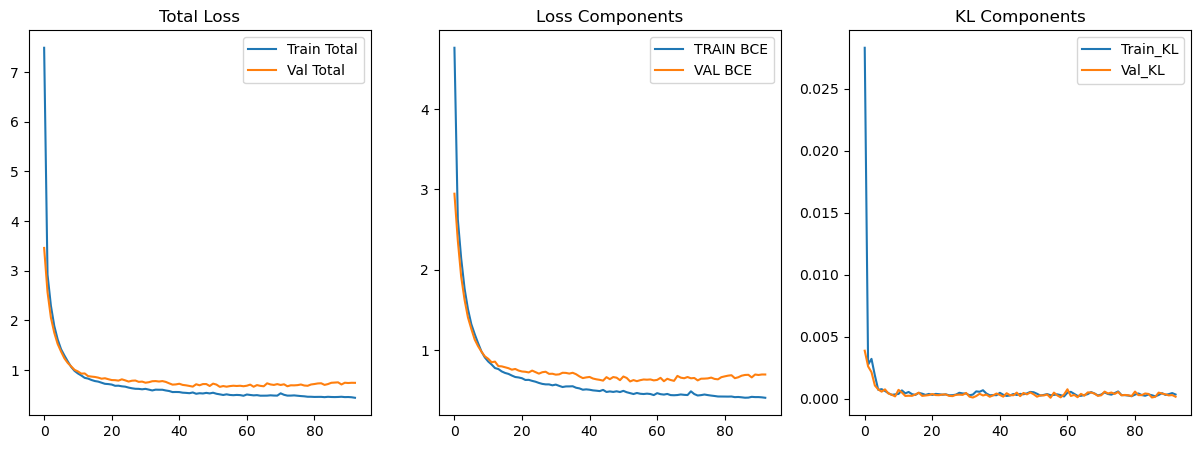

In [10]:
# 5. 결과 시각화
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.plot(history['train_loss'], label='Train Total')
plt.plot(history['val_loss'], label='Val Total')
plt.title('Total Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(history['train_bce'], label='TRAIN BCE')
plt.plot(history['val_bce'], label='VAL BCE')
plt.title('Loss Components')
plt.legend()

plt.subplot(1,3,3)
plt.plot(history['train_kl'],label ='Train_KL')
plt.plot(history['val_kl'], label = 'Val_KL')
plt.title('KL Components')
plt.legend()
plt.show()

In [11]:
import joblib
import torch
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score, mean_absolute_error

# 1) 환경 및 데이터 준비
x_scaler = joblib.load('torch/abs_x_scaler.pkl')
c_scaler = joblib.load('torch/sta_c_scaler.pkl')
test_loader = torch.load('torch/test_loader.pt', weights_only=False)


In [12]:
early_stopping.load_best_model(model)
model.eval()

all_x_true = [] #실제값(Scaled)
all_x_pred = [] # 복원값(Scaled)
all_mask_prob = [] # 존재확률 [0,1]
all_c_condition = [] # 사용된 조건(c)
all_c_true = []

with torch.no_grad():
    for x_t, c_t in test_loader:
        x_t,c_t = x_t.to(device),c_t.to(device)

        bce_logit, binary_out,x_hat,z_mu,z_logvar,c_hat= model(x_t,c_t)

        #확률 및 최종 복원값 계산
        prob_mask = torch.sigmoid(bce_logit)
        all_x_true.append(x_t.cpu().numpy())
        all_c_true.append(c_t.cpu().numpy())
        all_x_pred.append(x_hat.cpu().numpy())
        all_mask_prob.append(prob_mask.cpu().numpy())
        all_c_condition.append(c_hat.cpu().numpy())

all_x_true = np.vstack(all_x_true)
all_x_pred = np.vstack(all_x_pred)
all_c_condition = np.vstack(all_c_condition)
all_c_true = np.vstack(all_c_true)
all_mask_prob = np.vstack(all_mask_prob)
# all_x_pred = np.maximum(all_x_pred,0)
x_true_raw = x_scaler.inverse_transform(all_x_true)
x_hat_raw = x_scaler.inverse_transform(all_x_pred)
c_hat_raw = c_scaler.inverse_transform(all_c_condition)
c_true_raw = c_scaler.inverse_transform(all_c_true)



Restored best model with loss: 0.664677


### ch4 r2_score

In [13]:
from sklearn.metrics import r2_score, mean_squared_error
x_true = x_true_raw.flatten()
x_pred = x_hat_raw.flatten()
rmse = np.sqrt(mean_squared_error(x_true,x_pred))
r2 = r2_score(x_true,x_pred)
r2


0.8320726156234741

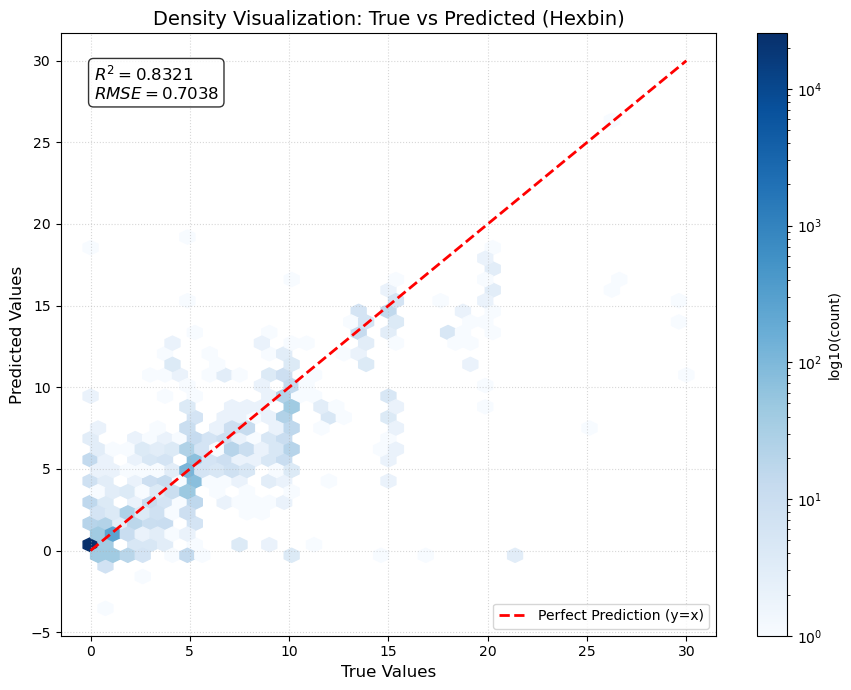

In [21]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error

# 데이터 준비 (x_true, x_pred)
x_true = x_true_raw.flatten()
x_pred = x_hat_raw.flatten()

rmse = np.sqrt(mean_squared_error(x_true, x_pred))
r2 = r2_score(x_true, x_pred)

plt.figure(figsize=(9, 7))

# ---------------------------------------------------------
# 수정 포인트: Hexbin Plot 사용
# gridsize: 육각형의 크기 (높을수록 세밀함)
# bins='log': 밀집도가 너무 차이날 때 로그 스케일로 색상 표현 (권장)
# ---------------------------------------------------------
hb = plt.hexbin(x_true, x_pred, gridsize=40, cmap='Blues', bins='log', mincnt=1)
cb = plt.colorbar(hb, label='log10(count)')

# y=x 대각선
max_val = max(x_true.max(), x_pred.max())
plt.plot([0, max_val], [0, max_val], 'r--', lw=2, label='Perfect Prediction (y=x)')

# 지표 표시
textstr = f'$R^2 = {r2:.4f}$\n$RMSE = {rmse:.4f}$'
plt.gca().text(0.05, 0.95, textstr, transform=plt.gca().transAxes, fontsize=12,
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.xlabel('True Values', fontsize=12)
plt.ylabel('Predicted Values', fontsize=12)
plt.title('Density Visualization: True vs Predicted (Hexbin)', fontsize=14)
plt.legend(loc='lower right')
plt.grid(True, linestyle=':', alpha=0.5)

plt.tight_layout()
plt.show()

In [23]:
x_true_raw.shape

(1182, 23)

In [15]:
standard_support = ['Al2O3_Gamma', 'Al2O3_Alpha', 'Al2O3_Mesoporous', 'BN', 'SBA-15', 'SiO2', 'MCM-41', 'ZSM-5', 'Si3N4', 'H-ZSM-5']
promot_support = ['LaNi0.9Ru0.1O3', 'LaNi0.8Ru0.2O3', 'La3.5Ru4O3', 'Sr0.92Y0.08Ti1.95Rh0.05O3', 'La2NiO4', 'LaCoO3', 'LaCuO3', 'LaRuO3', 'LaNiO3', 'LaMnO3', 'LaNiCoMnO3', 'La2Ni0.5F0.5O4', 'LaNi0.5Fe0.5O3', 'LaNi0.8Zn0.2O3', 'LaNi0.6Zn0.4O3', 'LaNi0.4Zn0.6O3', 'LaNi0.2Zn0.8O3', 'LaZnO3', 'La2O3', 'BaO', 'CaO', 'MgO', 'MgO_Nanocrystalline', 'MgAl2O4(nanocry)', 'CeO2', 'TiO2', 'PrO2', 'V2O5', 'ZrO2', 'nanocrystalline_ZrO2', 'MnO', 'Y2O3', 'MgAlOx', 'CoOx', 'Si3N4', 'H-ZSM-5', 'Ce0.8Pr0.2O2']
active_metal = ['Co', 'Cu', 'Ir', 'Mn', 'Ni', 'Pd', 'Pt', 'Rh', 'Ru','Fe']# 10
promoter = ['Ba', 'Ca', 'Ce', 'La', 'Ag', 'Mg', 'Au', 'K', 'Li', 'Pr', 'Sr', 'Y', 'Zr']#13

In [16]:
df_meta = pd.read_csv('211210-DRM-total.csv')
metal_columns = df_meta.loc[:, active_metal].columns

In [17]:
print(x_true_raw[8],x_hat_raw[8])

[0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.05 0.   0.   0.   0.   0.   0.  ] [ 0. -0.  0.  0.  0. -0.  0.  0.  0.  0.  0. -0.  0.  0.  0.  0. -0.  0.
  0.  0.  0.  0.  0.]


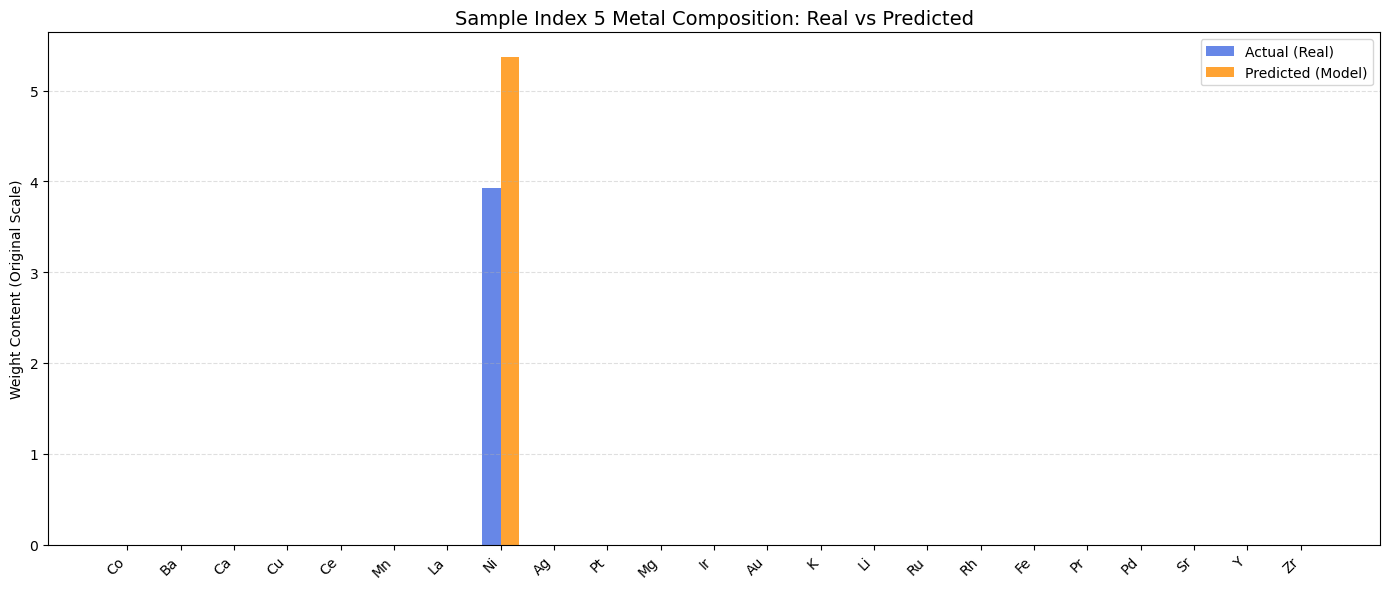

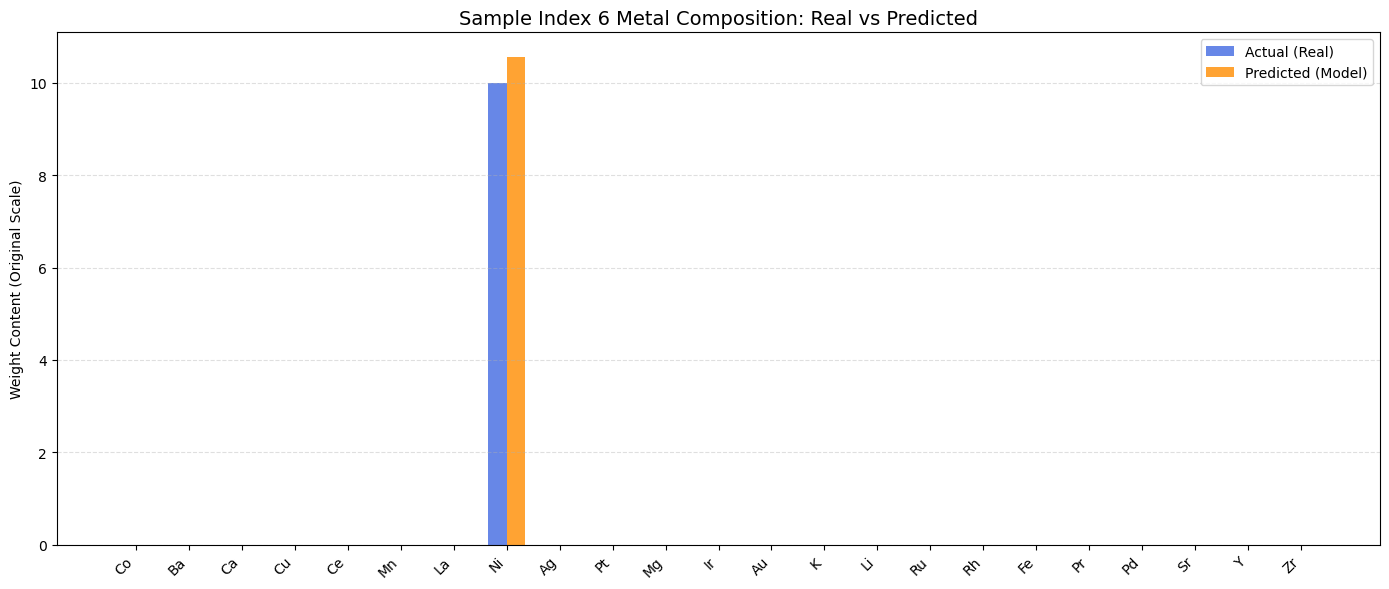

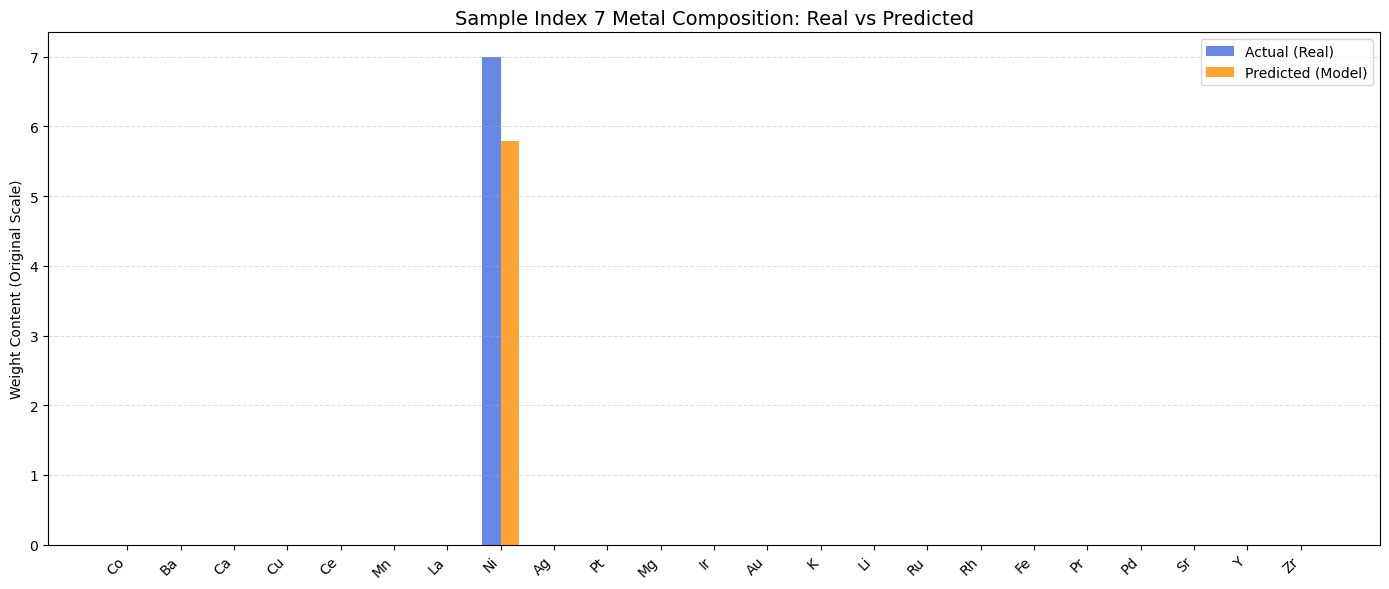

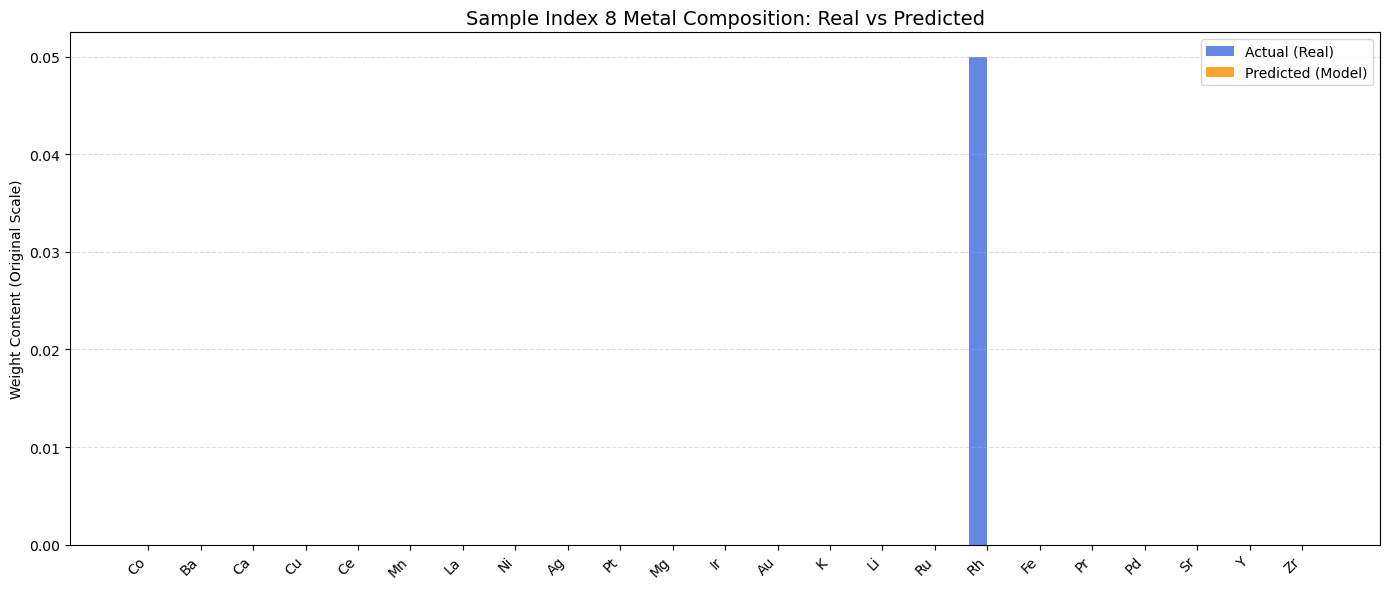

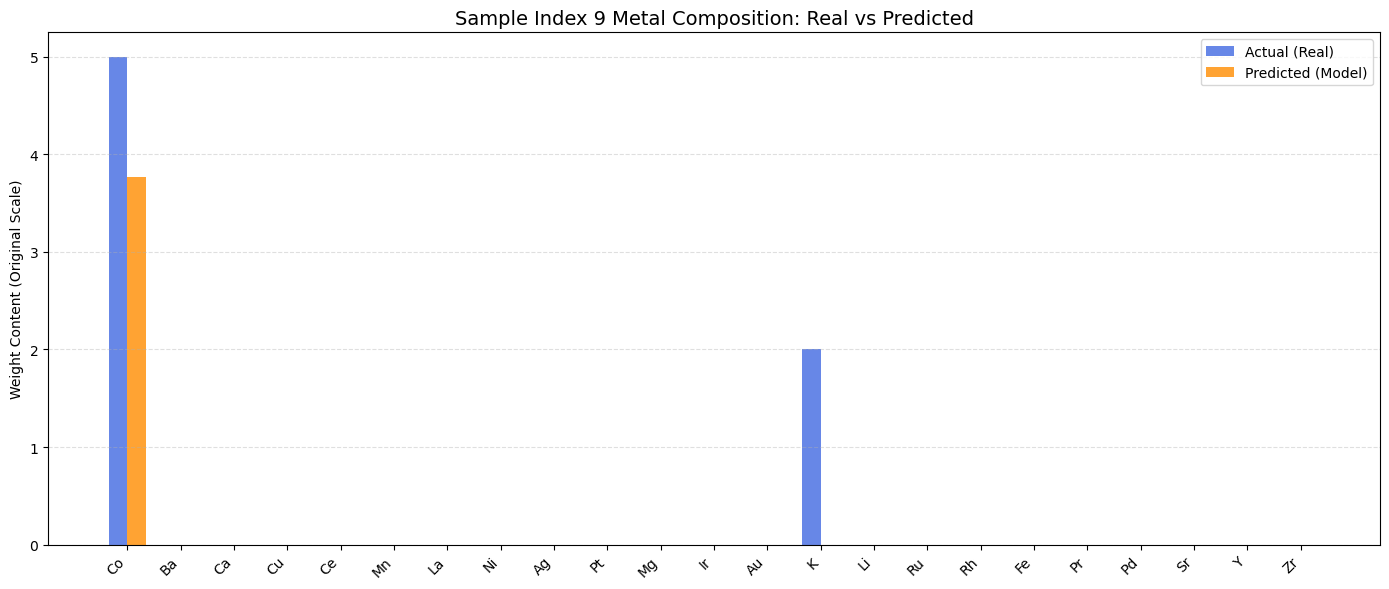

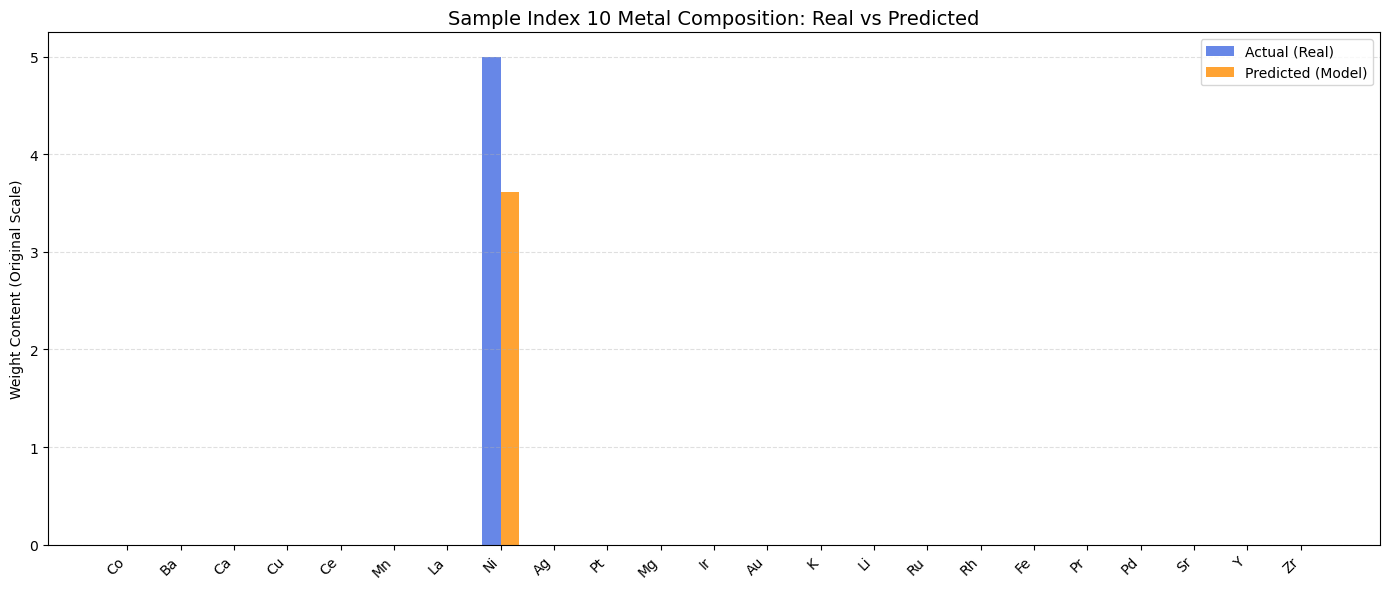

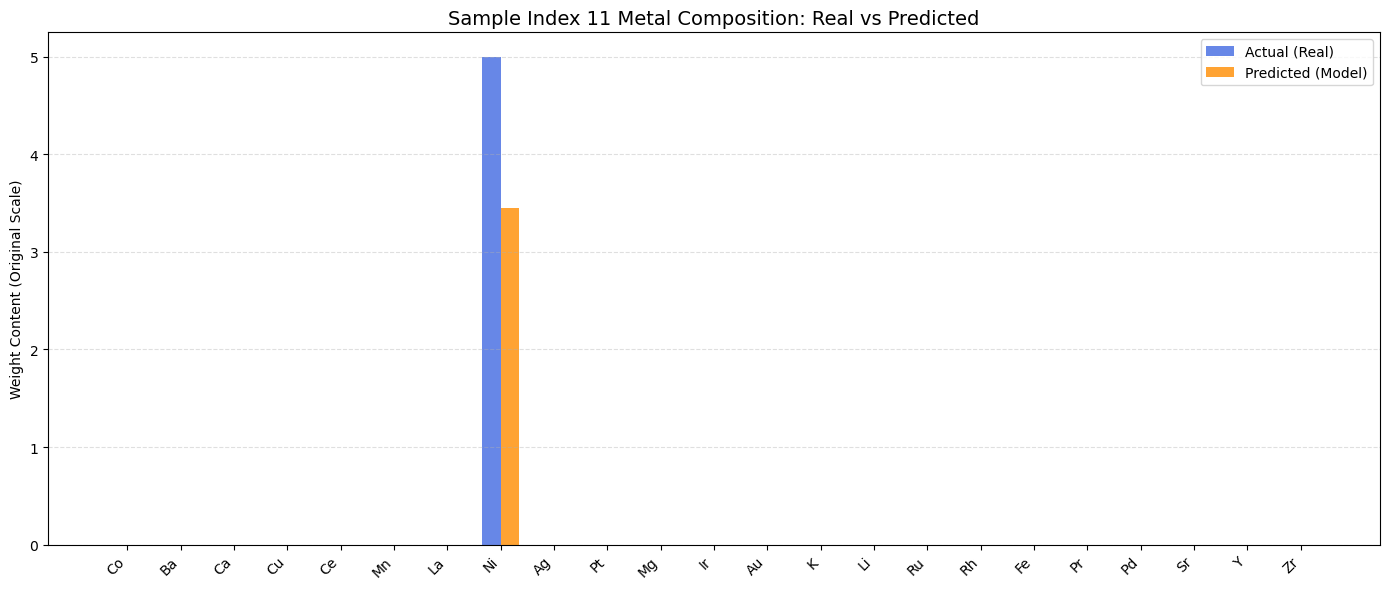

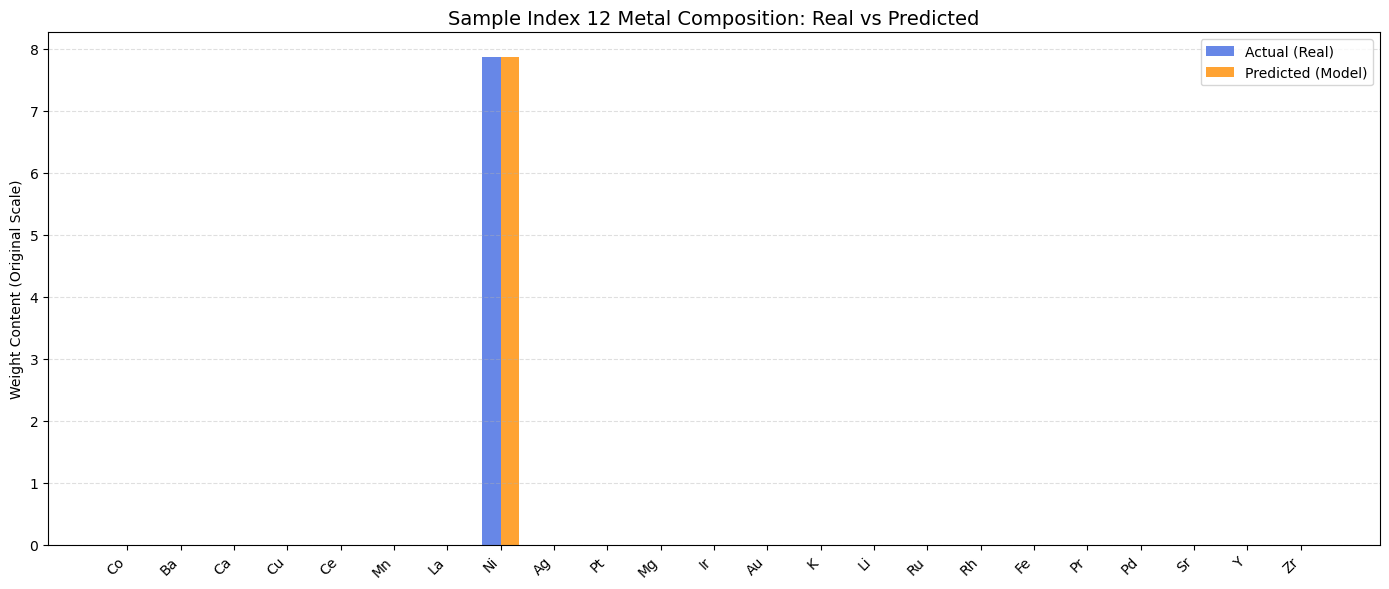

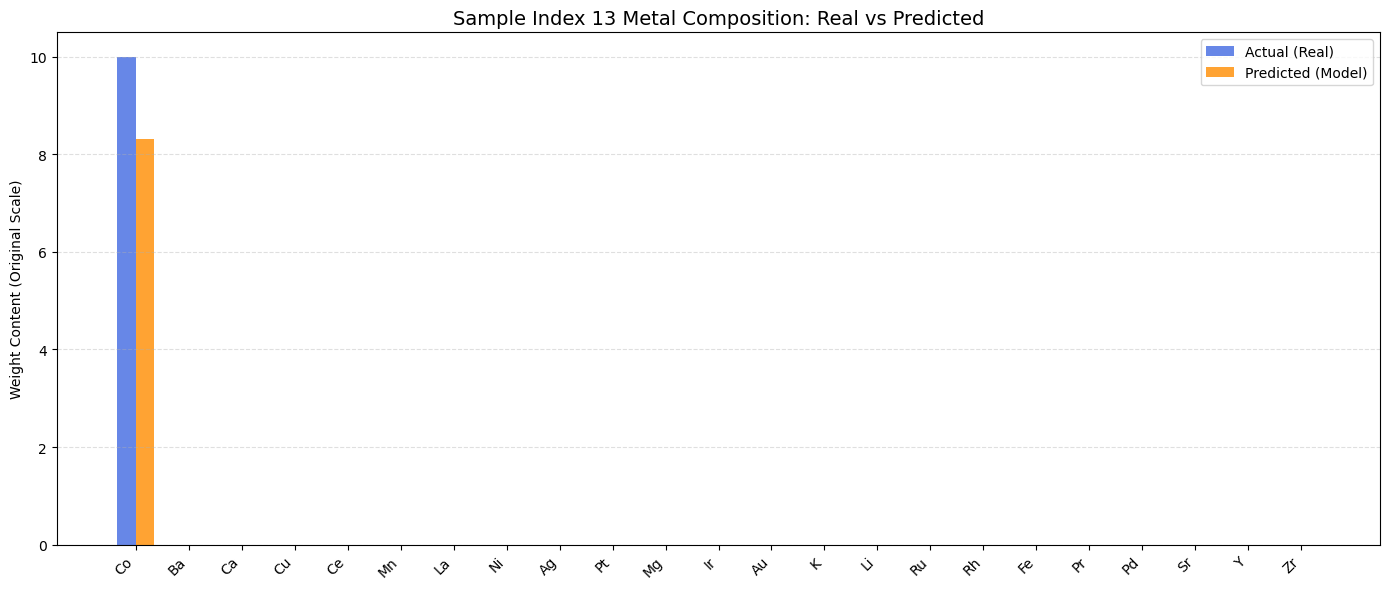

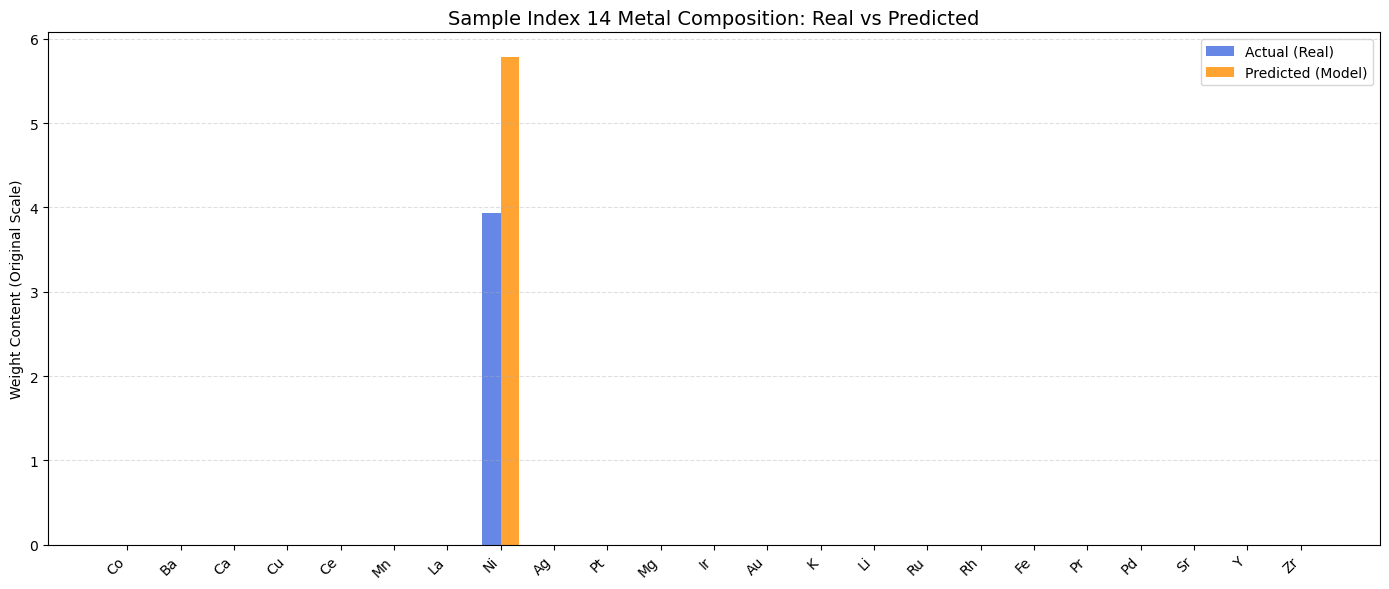

In [18]:
df_meta = pd.read_csv('211210-DRM-total.csv')
df_metal = df_meta.iloc[:,2:25]
metal_columns = df_metal.columns
for i in range(5, 15):
    plt.figure(figsize=(14, 6))
    x_axis = np.arange(23)
    width = 0.35
    
    plt.bar(x_axis - width/2, x_true_raw[i], width, label='Actual (Real)', color='royalblue', alpha=0.8)
    plt.bar(x_axis + width/2, x_hat_raw[i], width, label='Predicted (Model)', color='darkorange', alpha=0.8)
    
    plt.xticks(x_axis, metal_columns, rotation=45, ha='right')
    plt.title(f'Sample Index {i} Metal Composition: Real vs Predicted', fontsize=14)
    plt.ylabel('Weight Content (Original Scale)')
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.4)
    plt.tight_layout()
    plt.show()